In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

    
Nesse notebook tive que fazer algumas modificações no Spin-flip. O algoritmo de Metropolis que determina a dinâmica de mudança do spin é regida por uma variação de energia. Como nosso sistema tem o termo de interação $J_i(r_{ij}) = 1/r_{ij}^\alpha$, é de se esperar que a variação da energia também dependa deste termo. Então, a modificação da função ``spin_flip`` foi justamente a inclusão deste termo. Para isso, precisei incluir a linha ``ji = np.arange(1,N)**alpha`` para gerar uma espécie de vetor de distâncias. Para conseguir gerar a distância corretamente, utilizei o termo ``jr = ji[:a]`` ($j$ reverso) e em seguida, no cálculo de ``nb``, ``jr[::-1]``, isso porquê, quando seleciono um spin aleatório, preciso avaliar as distâncias dos spins da frente e os de trás, como no exemplo abaixo. Note que em ``print(distâncias)``, um dos arrays está invertido, pois ele está avaliando exatamente as distâncias do spin $a$ com os que vêm antes.

A diferença substancial nessa modificação pode ser vista na mudança dos gráficos, à medida que aumentamos os valores de $\alpha$ vemos como os gráficos se aproximam do eixo das ordenadas. A teoria afirma que, quando $\alpha> 2$, não ha transição de fase. Caso $\alpha <1$ entramos em outro tipo de dinâmica, a força de interação aumenta com o aumento da distância (não estamos intereçados nisso). Portanto, avaliamos as interações no intervalo $1\leq\alpha < 2$

Como este notebook simula apenas as interações sem campo, só long alcance (LRIM - Longe Range Ising Model), retirei tudo que remete ao campo, há outro notebook com a inclusão do campo gaussiano aleatório.

No meu computador, esse notebook está rodando em cerca de 10 minutos para cada $\alpha$, leva cerca de 50 minutos para gerar a figura com 4 valores diferentes de uma vez.

In [2]:
@jit(forceobj=True)
def inicial(N):
    state = 2*np.random.randint(2,size=N)-1
    return state

N = 10
ji = np.arange(1,N)
config = inicial(N)
print("spins",config)
a = np.random.randint(N)
print("posição",a+1)
print(f"spin[{a+1}]",config[a])
print("vizinhos",config[:a],config[a+1:])
jr = ji[:a]
print("distâncias",jr[::-1],ji[:N-a-1])

spins [ 1  1 -1 -1 -1 -1 -1 -1  1  1]
posição 8
spin[8] -1
vizinhos [ 1  1 -1 -1 -1 -1 -1] [1 1]
distâncias [7 6 5 4 3 2 1] [1 2]


In [3]:
# Initial state
@jit(forceobj=True)
def inicial(N):
    state = 2*np.random.randint(2,size=N)-1
    return state

# Spin flip
@jit(forceobj=True)
def spin_flip(N,beta,config,alpha):
    rindex = np.random.randint(N, size=N)
    ji = np.arange(1,N)**alpha
    for a in rindex:
        s = config[a]
        jr = ji[:a]
        nb = (config[:a]/jr[::-1]).sum() + (config[a+1:]/ji[:N-a-1]).sum()
        cost = 2*s*nb # cost = 2*E (E1 - E0 = 2E)
        if cost < 0:
            s *= -1
        elif np.random.rand() < np.exp(-cost*beta):
            s *= -1
        config[a] = s
    return config

# Energy
@jit(forceobj=True)
def energy(N, config,alpha):
    e = 0
    ji = np.arange(1,N)**alpha
    for i in range(N):
        e += (-config[i]*config[i+1:]/ji[:N-i-1]).sum()
    return e

# Magnetization
@jit(forceobj=True)
def magnetization(N,config):
    m = config.sum()
    return m

In [4]:
nt     = 100        #  number of temperature points
N      = 2**10       #  size of the lattice, N
alpha = np.array([1.,1.4,1.8,2.2])        #  exponent of the long range interaction

eqSteps = 1000       #  number of MC sweeps for equilibration
mcSteps = 1000       #  number of MC sweeps for calculation

# valores de temperatura
T       = np.linspace(1, 15, nt);

#  arrays para armazenar os valores médios
E,M,C,X,Cr,Rho = np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros((len(alpha),nt)), np.zeros(nt), np.zeros(nt)


n1, n2  = 1.0/(mcSteps*N), 1.0/(mcSteps*mcSteps*N)

FileNotFoundError: [Errno 2] No such file or directory: 'Imagens/1d_lrim_N1024_mcS1000_eq1000.png'

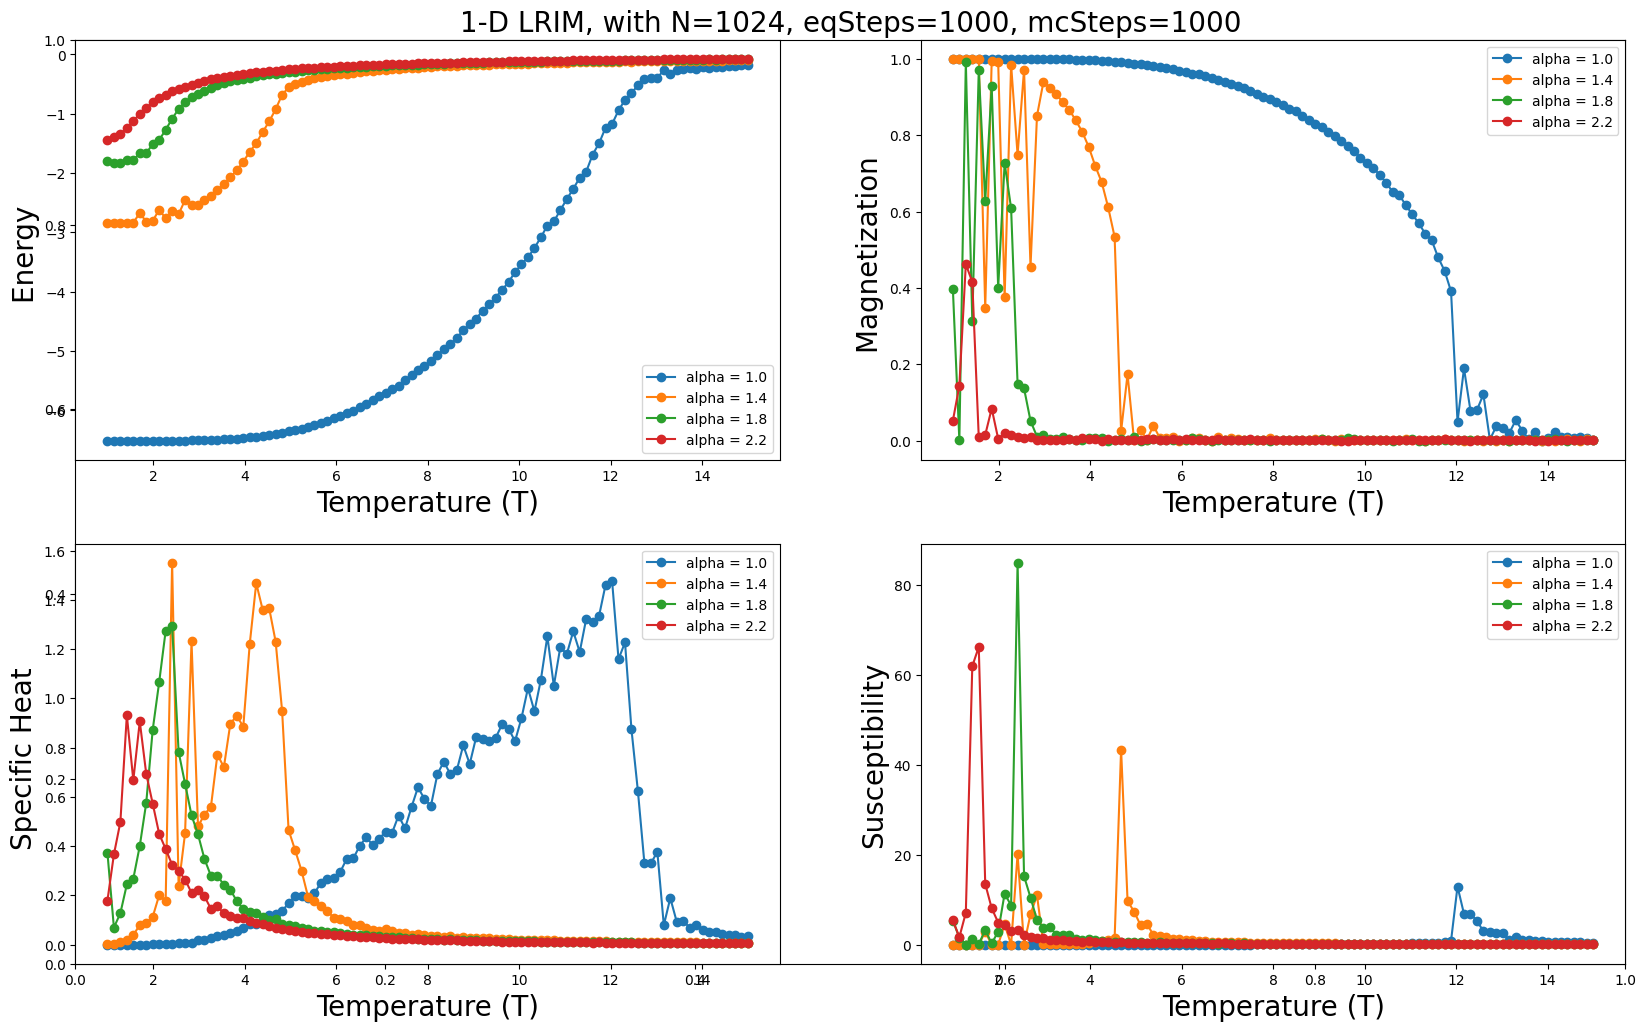

In [5]:
# Funcoes variando com a temperatura
for j in range(len(alpha)):

    for tt in range(nt):
        E1 = M1 = E2 = M2 = 0
        config = inicial(N)
        iT=1/T[tt]; iT2=iT*iT; # Termos referentes à temperatura => beta = 1/kT, k=1 é a constante de Boltzmann

        for i in range(eqSteps):         # equilibrate
            spin_flip(N,iT,config,alpha[j])         # Monte Carlo moves

        for i in range(mcSteps):
            spin_flip(N,iT,config,alpha[j])
            Ene = energy(N,config,alpha[j])     # calculate the energy
            Mag = magnetization(N,config)        # calculate the magnetisation

            E1 = E1 + Ene
            M1 = M1 + Mag
            M2 = M2 + Mag*Mag
            E2 = E2 + Ene*Ene

        E[j][tt] = E1*n1
        M[j][tt] = M1*n1
        C[j][tt] = (E2*n1 - E1*E1*n2)*iT2
        X[j][tt] = (M2*n1 - M1*M1*n2)*iT

f = plt.figure(figsize=(20, 12)); # plot the calculated values

plt.title(f'1-D LRIM, with N={N}, eqSteps={eqSteps}, mcSteps={mcSteps}', fontsize=20);

sp =  f.add_subplot(2, 2, 1 );
for j in range(len(alpha)):
    plt.plot(T, E[j],'-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Energy ", fontsize=20);
    plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 2 );
for j in range(len(alpha)):
    plt.plot(T, abs(M)[j],'-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Magnetization ", fontsize=20);
    plt.legend(loc='best');

sp =  f.add_subplot(2, 2, 3 );
for j in range(len(alpha)):
    plt.plot(T, C[j], '-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Specific Heat ", fontsize=20);
    plt.legend(loc='best');ß

sp =  f.add_subplot(2, 2, 4 );
for j in range(len(alpha)):
    plt.plot(T, X[j], '-o', label='alpha = %s' % alpha[j]);
    plt.xlabel("Temperature (T)", fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    plt.legend(loc='best');

plt.savefig(f'Imagens/1d_lrim_N{N}_mcS{mcSteps}_eq{eqSteps}.png', bbox_inches='tight')
